## Selecting band comparison segments

In [1]:
import numpy as np
from PIL import Image
from glob import glob
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mahotas

In [2]:
img_paths = sorted(glob('scenes_pca/*'))
truth_paths = sorted(glob('truth_masks/*'))
slic_paths = sorted(glob('slics/*pca.npy'))
assert len(img_paths) == len(truth_paths) == len(slic_paths)

In [3]:
# 0 - Fundo
# 1 - Desmatamento recente
# 2 - Floresta
# 3 - Ñ analisado

def is_mixed(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 2)
    NP = np.count_nonzero(segment) # desconsiderando o fundo (np.zeros)
    NNP = NP - NFP

    if NFP != 0 and NNP != 0:
        return True
    

    return False
    
def get_hor(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 2)
    NP = np.count_nonzero(segment) # desconsiderando o fundo
    NNP = NP - NFP

    HoR = max([NFP, NNP]) / NP

    return HoR

def get_major_class(segment):
    if np.argmax(np.bincount(segment.flatten())) == 2:
        return "forest"
    elif np.argmax(np.bincount(segment.flatten())) == 1:
        return "non forest"
    elif np.argmax(np.bincount(segment.flatten())) == 3:
        return "not analyzed"
    else:
        return np.argmax(np.bincount(segment.flatten()))

In [4]:
segments_image_df = []
segments_truth_df = []

In [5]:
global_segment_array = []
global_perfect_segments = []
for idx in range(len(img_paths)):
    total_segs = 0
    good_segs = 0
    bad_by_hor = 0
    bad_by_size = 0
    n_perfect_segs = 0
    image = np.asarray(Image.open(img_paths[idx]))
    truth = np.load(truth_paths[idx])
    slic = np.load(slic_paths[idx])

    props = regionprops(slic)
    segments_truth = []
    segments_image = []
    bad_segment_ids = []
    perfect_segs_truth = []

    assert slic.shape[:2] == truth.shape[:2]
    for i, prop in enumerate(props):
        total_segs += 1
        minr, minc, maxr, maxc = prop.bbox
        segment_truth = np.zeros((maxr - minr, maxc - minc))
        segment_image = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
        coords = np.array(prop.coords)
        for pixel in coords:
            segment_truth[pixel[0] - minr, pixel[1] - minc] = truth[pixel[0], pixel[1]]
            segment_image[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
        hor = get_hor(segment_truth)
        classification = get_major_class(np.uint8(segment_truth))
        if (segment_truth.shape[0] * segment_truth.shape[1] > 70) and (hor > 0.7) and (classification in ["forest", "non forest"]):
            segments_truth.append(np.uint8(segment_truth))
            segments_image.append(np.uint8(segment_image))
            segments_image_df.append({"Segment_label": prop.label, "HoR": hor, "Class": classification, "Region": f'x{idx + 1 :02d}'})
            segments_truth_df.append({"Segment_label": prop.label, "HoR": hor, "Class": classification, "Region": f'x{idx + 1 :02d}'})
            good_segs += 1
        if (hor<= 0.7):
            bad_by_hor += 1
            bad_segment_ids.append(prop.label)
        if (segment_truth.shape[0] * segment_truth.shape[1] <= 70 or classification == 0):
            bad_by_size += 1
            bad_segment_ids.append(prop.label)
        if (hor== 1):
            perfect_segs_truth.append(segment_truth)
            n_perfect_segs += 1
    global_segment_array.append(segments_truth)
    global_perfect_segments.append(perfect_segs_truth)

    print(f'x{idx + 1 :02d}: total_segs = {total_segs} | good_segs = {good_segs} | bad_segs = {total_segs - good_segs} | bad_segs because of HoR = {bad_by_hor} | bad_segs because of size = {bad_by_size} | perfect_segs = {n_perfect_segs}')

    

x01: total_segs = 3551 | good_segs = 1692 | bad_segs = 1859 | bad_segs because of HoR = 181 | bad_segs because of size = 1276 | perfect_segs = 2551
x02: total_segs = 3577 | good_segs = 1249 | bad_segs = 2328 | bad_segs because of HoR = 282 | bad_segs because of size = 1273 | perfect_segs = 1991
x03: total_segs = 3482 | good_segs = 1192 | bad_segs = 2290 | bad_segs because of HoR = 356 | bad_segs because of size = 1536 | perfect_segs = 1668
x04: total_segs = 3613 | good_segs = 484 | bad_segs = 3129 | bad_segs because of HoR = 448 | bad_segs because of size = 1662 | perfect_segs = 1483
x05: total_segs = 3255 | good_segs = 648 | bad_segs = 2607 | bad_segs because of HoR = 701 | bad_segs because of size = 2150 | perfect_segs = 943
x06: total_segs = 3665 | good_segs = 1121 | bad_segs = 2544 | bad_segs because of HoR = 438 | bad_segs because of size = 1147 | perfect_segs = 1707
x07: total_segs = 3706 | good_segs = 2025 | bad_segs = 1681 | bad_segs because of HoR = 509 | bad_segs because of s

In [6]:
segments_image_df = pd.DataFrame.from_records(segments_image_df)
segments_truth_df = pd.DataFrame.from_records(segments_truth_df)

In [7]:
segments_image_df.head()

,Segment_label,HoR,Class,Region
0,1,1.0,forest,x01
1,2,1.0,forest,x01
2,4,1.0,forest,x01
3,5,1.0,forest,x01
4,6,1.0,forest,x01


In [8]:
for idx, segment_list in enumerate(global_segment_array):
    forest_count = 0
    non_forest_count = 0
    for segment in segment_list:
        if (np.argmax(np.bincount(segment.flatten())) == 2):
            forest_count += 1
        elif (np.argmax(np.bincount(segment.flatten())) == 1):
            non_forest_count += 1
    
    print(f'across x{idx + 1 :02d}: forest = {forest_count} | non forest = {non_forest_count}')



across x01: forest = 1585 | non forest = 107
across x02: forest = 1115 | non forest = 134
across x03: forest = 1167 | non forest = 25
across x04: forest = 475 | non forest = 9
across x05: forest = 612 | non forest = 36
across x06: forest = 1104 | non forest = 17
across x07: forest = 2016 | non forest = 9
across x08: forest = 928 | non forest = 36
across x09: forest = 1582 | non forest = 19
across x10: forest = 820 | non forest = 35


In [9]:
# segments_image_df.to_csv('segments_pca.csv', index=False)

In [10]:
# for i in range(1, 11):
#     fig = plt.figure(figsize=(5, 5))
#     data = segments_truth_df[segments_truth_df['Region'] == f'x{i:02d}']
#     data = data.reset_index(drop=True)

#     ax = sns.boxplot(data, x='Class', y='HoR')
#     ax.set_title(f'Boxplot | x{i :02d}')


Text(0.5, 1.0, 'Boxplot | all regions')

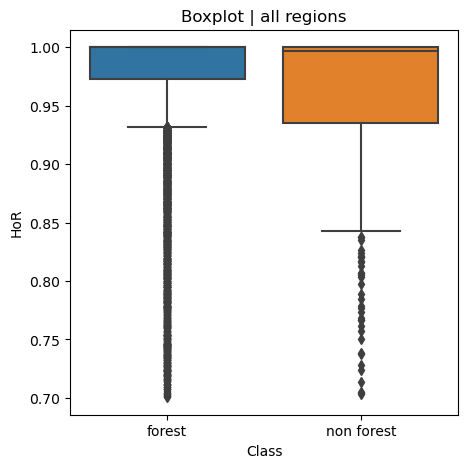

In [11]:
fig = plt.figure(figsize=(5, 5))
data = segments_truth_df
data = data.reset_index(drop=True)
ax = sns.boxplot(data, x='Class', y='HoR')
ax.set_title(f'Boxplot | all regions')


In [12]:
info = []
for i in range(1, 11):
    region_segments = segments_image_df[segments_image_df['Region'] == f'x{i :02d}']
    counts = region_segments['Class'].value_counts()
    # export_num = min([counts['forest'], counts['non forest'], 100])
    
    # selecting segments
    selected_segments = region_segments.sort_values(by='HoR', ascending=False)
    # selected_segments = selected_segments.groupby('Class')

    # exporting segments
    print(selected_segments.shape)
    # getting labels
    # forest_labels = (selected_segments[selected_segments['Class'] == 'forest'])['Segment_label'].values
    # non_forest_labels = selected_segments[selected_segments['Class'] == 'non forest']['Segment_label'].values

(1692, 4)
(1249, 4)
(1192, 4)
(484, 4)
(648, 4)
(1121, 4)
(2025, 4)
(964, 4)
(1601, 4)
(855, 4)


## Calculating Haralick features for every band and saving segment files

In [13]:
info = []
for i in range(1, 11):
    region_segments = segments_image_df[segments_image_df['Region'] == f'x{i :02d}']
    counts = region_segments['Class'].value_counts()
    # export_num = min([counts['forest'], counts['non forest'], 100])
    
    # selecting segments
    selected_segments = region_segments.sort_values(by='HoR', ascending=False)
    # selected_segments = selected_segments.groupby('Class')

    # exporting segments

    # getting labels
    forest_labels = (selected_segments[selected_segments['Class'] == 'forest'])['Segment_label'].values
    non_forest_labels = selected_segments[selected_segments['Class'] == 'non forest']['Segment_label'].values

    # loading scenes
    image = np.load(f'scenes_allbands/allbands_x{i :02d}.npy')
    slic = np.load(f'slics/slic_x{i :02d}-pca.npy') #b4b6b7 composition
    props = regionprops(slic)

    
    # saving segments
    saved_forest = 0
    saved_nonforest = 0
    for prop in props:
        if prop.label in forest_labels:
            minr, minc, maxr, maxc = prop.bbox
            image_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
            coords = np.array(prop.coords)
            for pixel in coords:
                image_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
            
            img = np.uint8(image_segment)
            har_bands = []

            for band in range(img.shape[-1]):
                har_forest = mahotas.features.haralick(img[:, :, band])
                har_bands.append(har_forest)
        
            img = np.stack(har_bands)

            # np.save(f'data/dataset_v4-pca/forest/forest_x{i :02d}_{prop.label}.npy', img)
            saved_forest += 1

        if prop.label in non_forest_labels:
            minr, minc, maxr, maxc = prop.bbox
            image_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
            coords = np.array(prop.coords)
            for pixel in coords:
                image_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
            
            img = np.uint8(image_segment)
            har_bands = []
            
            for band in range(img.shape[-1]):
                har_forest = mahotas.features.haralick(img[:, :, band])
                har_bands.append(har_forest)
        
            img = np.stack(har_bands)

            # np.save(f'data/dataset_v4-pca/non_forest/nonforest_x{i :02d}_{prop.label}.png', img)
            saved_nonforest += 1
    info.append(dict(region=f'x{i :02d}', forest=saved_forest, nonforest=saved_nonforest, total=(saved_forest + saved_nonforest)))
        
    # assert (saved_forest == export_num) and (saved_nonforest == export_num)

In [14]:
log = pd.DataFrame.from_records(info)
log

,region,forest,nonforest,total
0,x01,1585,107,1692
1,x02,1115,134,1249
2,x03,1167,25,1192
3,x04,475,9,484
4,x05,612,36,648
5,x06,1104,17,1121
6,x07,2016,9,2025
7,x08,928,36,964
8,x09,1582,19,1601
9,x10,820,35,855


In [15]:
log.sum()

region       x01x02x03x04x05x06x07x08x09x10
forest                                11404
nonforest                               427
total                                 11831
dtype: object